# Point Cloud Neural Operator

<img src="architecture.png" width="1200" />

The Point Cloud Neural Operator (PCNO) is a neural network - based surrogate model framework meticulously designed to approximate solution maps of parametric partial differential equations (PDEs) on intricate and variable geometries. Given an abstract parametric PDE $$\mathcal{R}(u, a) = 0$$ defined on $\Omega \subset \mathbb{R}^{d}$, where $\mathcal{R}$ represents a generalized differential operator, $a: \mathbb{R}^{d} \to \mathbb{R}^{d_{a}}$ stands for the parameter function, and $u(x): \mathbb{R}^{d} \to \mathbb{R}^{d_{u}}$ denotes the solution function. The overarching objective of PCNO is to approximate the solution map 
$$\mathcal{G}^{\dagger}:(a, \Omega) \mapsto u.$$

## Point Cloud Neural Operator

The Point Cloud neural layer $\mathcal{L}$ serves to map the input function $f_{\rm in}: \Omega \rightarrow \mathbb{R}^{d_{\rm in}}$ to the output function $f_{\rm out}: \Omega \rightarrow \mathbb{R}^{d_{\rm out}}$. This mapping is defined as follows:
$$
\begin{equation*}
\begin{split}
    &\mathcal{L} : f_{\rm in} \mapsto f_{\rm out}, \\
    &f_{\rm out}(x) =  \sigma \Bigl(W^{l} f_{\rm in}(x) + b + \sum_k\int_{\Omega} e^{-2\pi i\frac{k}{L}(x - y)}W_k^vf_{\rm in}(y)\rho(y,\Omega) {\rm d}y + W^g\tilde{\nabla}f_{in}\Bigr).\
\end{split}
\end{equation*}
$$
Here, $W^{l}\in\mathbb{R}^{d_{\rm out}\times d_{\rm in}}$, $b\in\mathbb{R}^{d_{\rm out}}$, $W_k^v\in\mathbb{C}^{d_{\rm out}\times d_{\rm in}},W_g \in\mathbb{R}^{d_{\rm out}\times (d\cdot d_{\rm in})}$ all operate pointwise.
- The linear term $W^{l} f_{\rm in}(x) + b$ represent the standard linear transformation.
- The integral term $\sum_k\int_{\Omega} e^{-2\pi i\frac{k}{L}(x - y)}W_k^vf_{\rm in}(y)\rho(y,\Omega) {\rm d}y$ captures the long - range dependencies in the domain $\Omega$. 
- The gradient term $W^g\tilde{\nabla}f_{in}$incorporates the local gradient information of the input function $f_{in}$, which can help the network better understand the local behavior of the data.



## Parametrization and Computation 

### integral operator

We establish a connection between the geometry $\Omega$ and a density function $\rho(x ; \Omega)$ defined on $\Omega$. The integral operator is formulated as:
$$
f_{\rm out}(x)=\sum_k \int_{\Omega} e^{2\pi i\frac{k}{L}(x - y)}W_k^vf_{\rm in}(y)\rho(y;\Omega) {\rm d}y
$$
where $W_k^{v} \in \mathbb{C}^{d_{out} \times d_{in}}$ is a parameter matrix. The density function $\rho(x ; \Omega)$ plays a crucial role in ensuring the stability of the integral during the training process. It also simplifies the numerical integration, as it allows for a more efficient approximation of the integral over the complex domain $\Omega$.

Consider a set of bases $\{\phi_k\}$ on $\Omega$. We define the weighted bases $\{\phi_{w,k}\}$ as
$$\phi_k(x) = e^{2\pi i\frac{k}{L}x}, \quad \phi_{w,k}(x_i) =  \overline{\phi_k(x_i)}\rho(x_i;\Omega){\rm d}\Omega_i$$
Then, we can rewrite the integral operator as follows:
$$
\begin{align*}
f_{\rm out}(x)&=\sum_k \int_{\Omega} e^{2\pi i\frac{k}{L}(x - y)}W_k^vf_{\rm in}(y)\rho(y;\Omega) {\rm d}y\\
&\approx  \sum_k\sum_i \phi_k(x)\overline{\phi_k(y_i)} W_k^vf_{\rm in}(y_i)\rho(y_i;\Omega) {\rm d}\Omega_i\\
&=  \sum_k \phi_k(x)W_k^v\sum_i\phi_{w,k}(y_i) f_{\rm in}(y_i)\\
&= \sum_k \phi_k(x)W_k^v\hat{f_{\rm in}}[k]\\
\end{align*}
$$
Since we are only concerned with the real part, to avoid complex - valued arithmetic operations, we can separately utilize the sine and cosine components. The computational process can be divided into three steps:

- **Step 1: Fourier - like Coefficient Computation**

Compute 
$$
\begin{align*}  
\hat{f}_{\rm in}^c[k] &= \langle\phi_{w,k}^c,f_{\rm in} \rangle ,\\
\hat{f}_{\rm in}^s[k] &= \langle\phi_{w,k}^s,f_{\rm in} \rangle,\\
\hat{f}_{\rm in}[0] &= \langle\phi_{w,0},f_{\rm in} \rangle.
\end{align*}$$
Here, $\phi_{w,k}^c$ and $\phi_{w,k}^s$ are the real part and the imaginary part of $\phi_{w,k}$ respectively. 

The corresponding codes are:
```python
x_c_hat =  torch.einsum("bix,bxkw->bikw", x, wbases_c)
x_s_hat = -torch.einsum("bix,bxkw->bikw", x, wbases_s)
x_0_hat =  torch.einsum("bix,bxkw->bikw", x, wbases_0)
```

- **Step 2: Transformed Coefficient Computation**

Compute
$$
\begin{align*}  
 &\widehat{Rf}^c_{\rm in}[k]  = R^c(k)\hat{f}^c_{\rm in}[k] - R^s(k)\hat{f}^s_{\rm in}[k] \\ 
 &\widehat{Rf}^s_{\rm in}[k] =  R^c(k)\hat{f}^s_{\rm in}[k] + R^s(k)\hat{f}^c_{\rm in}[k]  \\
 &\widehat{Rf}_{\rm in}[0] =  R^c(0)\hat{f}_{\rm in}[0]
\end{align*}$$
where $R^c(k)$ and $R^s(k)$ are real - valued martixs. The multiplication methods here originate from the complex multiplication of $W_k^v$.

The corresponding codes are:
```python
f_c_hat = torch.einsum("bikw,iokw->bokw", x_c_hat, weights_c) - torch.einsum("bikw,iokw->bokw", x_s_hat, weights_s)
f_s_hat = torch.einsum("bikw,iokw->bokw", x_s_hat, weights_c) + torch.einsum("bikw,iokw->bokw", x_c_hat, weights_s)
f_0_hat = torch.einsum("bikw,iokw->bokw", x_0_hat, weights_0) 
```
- **Step 3: Output Function Reconstruction**
$$
\begin{align*}
f_{\rm out} = \widehat{Rf}_{\rm in}[0]\phi_0 + 2\sum_k \widehat{Rf}_{\rm in}^c[k]\phi_k^c - 2\sum_k \widehat{Rf}_{\rm in}^s[k]\phi_k^s
\end{align*}$$
the factor of 2 and the negative sign here both come from taking the real part of the original complex multiplication.

The corresponding codes are:

```python
x = torch.einsum("bokw,bxkw->box", f_0_hat, bases_0)  
    + 2 * torch.einsum("bokw,bxkw->box", f_c_hat, bases_c) 
    - 2 * torch.einsum("bokw,bxkw->box", f_s_hat, bases_s)
```


### Differential Operator
We further define a differential operator to capture local effects. The gradient $\nabla f : \mathbb{R}^d\to\mathbb{R}^{d\times d_{in}}$ can be computed independently for each of the $d_{in}$ channels. For simplicity, we focus on the scalar function $f: \mathbb{R}^d \to \mathbb{R}$. 

Given a target node $x$ with neighbors $x^{(1)}, x^{(2)}, \ldots, x^{(m)}$, the fist order Tayler expansion is
$$
(x^{(i)} - x) \cdot\nabla f(x)\approx f(x^{(i)})-f(x)
$$

Therefore we estimate the gradient $\nabla f(x)$ by solving the least-squares problem:
$$
A(x)  \nabla f(x) = b_f(x)
$$
where
$$ A(x)  = \begin{pmatrix}
x^{(1)} - x\\
x^{(2)} - x\\
\vdots\\
x^{(m)} - x\\
\end{pmatrix} \in \mathbb{R}^{m \times d}
$$
and
$$
b_f(x) =  
 \begin{pmatrix}
f(x^{(1)}) - f(x)\\
f(x^{(2)}) - f(x)\\
\vdots\\
f(x^{(m)}) - f(x)\\
\end{pmatrix} \in \mathbb{R}^{m}.
$$

#### Compute the Pseudo-Inverse

The least-squares problem can be solved by computing the pseudo-inverse $A(x)^{\dagger} \in \mathbb{R}^{d \times m} $.  Since $A(x)^{\dagger}$ depends solely on the point cloud and its connectivity, it can be preprocessed before training.

- **Step 1: Truncated SVD**
  
    Special consideration is required when $\Omega$ is a submanifold of $\mathbb{R}^d$. Let $d^{'} \leq d$ denote the intrinsic dimension of $\Omega$. The truncated singular value decomposition of $A(x)$ with rank $d^{'}$ is given by
    $$
        A(x) = U\Sigma V^T
        
    $$
    where
    $$
     U\in \mathbb{R}^{m \times d^{'}},\quad\Sigma \in \mathbb{R}^{d^{'} \times d^{'}}, \quad V^T\in \mathbb{R}^{d^{'} \times d}.
    $$
    In practice, the rank $d^{'}$ is specified by the variable `rrank`, and a tolerance `rcond` is set to handle small singular values and avoid numerical instability.
    ```python
        u, s, vt = np.linalg.svd(a, full_matrices=False)
        cutoff = rcond * s[0]
        large = s > cutoff
        large[rrank:] = False
    ```

- **Step 2: Compute the Pseudo-Inverse**

    The pseudo-inverse is then computed as $A(x)^{\dagger} = V\Sigma^{-1} U^T$.
    ```python
        s = np.divide(1, s, where=large, out=s)
        s[~large] = 0
        res = np.matmul(np.transpose(vt), np.multiply(s[..., np.newaxis], np.transpose(u)))
    ```
 
 - **Step 3: Store On edges**
  
    The $i$-th column of $A(x)^{\dagger}$, denoted as $A_i(x)^{\dagger} \in \mathbb{R}^{d}$, can be stored at the directed edge $x \leftarrow x^{(i)}$ in `edge_gradient_weights`

#### Compute the gradient

The gradient $\nabla f(x) = A(x)^{\dagger}b_f(x)$ can be efficiently assembled using a message-passing procedure.

- **Step1: Compute the Message on Each Edge**
  
    For each directed edge $x\leftarrow x^{(i)}$, the message is computed as
    $$
    A_i(x)^{\dagger} \bigl(f(x^{(i)}) - f(x)\bigr)
    $$
    
    ```python
        target, source = directed_edges[...,0], directed_edges[...,1]
        message = torch.einsum('bed,bec->becd', edge_gradient_weights, f[torch.arange(batch_size).unsqueeze(1), source] - f[torch.arange(batch_size).unsqueeze(1), target]).reshape(batch_size, max_nedges, in_channels*ndims)
    ```
    
- **Step2: Aggregating the Information**
  
    Once the messages are computed, they need to be aggregated to form the gradient at each node. The gradient is the sum of all incoming messages to a node $x$
    $$
    \nabla f(x) = \sum_{x\leftarrow x^{(i)}} A_i(x)^{\dagger} \bigl(f(x^{(i)}) - f(x)\bigr).
    $$
    ```python
        f_gradients = torch.zeros(batch_size, max_nnodes, in_channels*ndims, dtype=message.dtype, device=message.device)
        f_gradients.scatter_add_(dim=1, src=message, index=target.unsqueeze(2).repeat(1,1,in_channels*ndims))
    ```

### Numerical Study
In the following, we test our algorithm by different examples

In [ ]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

from pcno.geo_utility import pinv
from pcno.pcno import compute_gradient

#### Example1: One Single point
Take $d = 2$, and suppose
$$f(x,y) = (x+1)^2 + (y+1)^2$$

We only consider 5 points 
$$x_0=(0,0), x_1 = (0,0.1), x_2=(0.1,0), x_3(0, -0.1), x_4(-0.1, 0)$$

[]

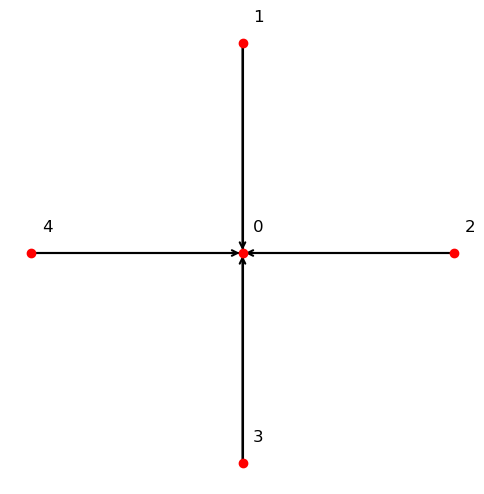

In [ ]:
def fval(nodes):
    nnodes, _ = nodes.shape
    f = np.zeros((1, nnodes))
    for i in range(nnodes):
        f[0, i] = (nodes[i, 0] + 1) ** 2 + (nodes[i, 1] + 1) ** 2
    return f

nodes = np.zeros((5, 2))
nodes[1, :] = np.array([0, 0.1])
nodes[2, :] = np.array([0.1, 0])
nodes[3, :] = np.array([0, -0.1])
nodes[4, :] = np.array([-0.1, 0])
f = torch.tensor(fval(nodes)[np.newaxis, ...])

directed_edges = np.zeros((4, 2), dtype=int)
for i in range(4):
    directed_edges[i, :] = np.array([0, i + 1])

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(nodes[:, 0], nodes[:, 1], color="red", zorder=5)
for i, (x, y) in enumerate(nodes):
    ax.text(x + 0.01, y + 0.01, f"{i}", fontsize=12, ha="right")

for edge in directed_edges:
    node_start, node_end = nodes[edge[0], :], nodes[edge[1], :]
    ax.plot([node_start[0], node_end[0]],[node_start[1], node_end[1]],color="black", zorder=1)
    dx, dy = node_end[0] - node_start[0], node_end[1] - node_start[1]
    ax.annotate("", xy=(node_end[0], node_end[1]), xytext=(node_start[0], node_start[1]), arrowprops=dict(facecolor="black", arrowstyle="<-", lw=1.5), zorder=3)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
dx = nodes[1:, :]
edge_gradient_weight = pinv(dx, 2)

print(f"dx: \n{dx}")
print(f"weight: \n{edge_gradient_weight}")
print(f"weight * dx: \n{np.matmul(edge_gradient_weight, dx)}")

dx: 
[[ 0.   0.1]
 [ 0.1  0. ]
 [ 0.  -0.1]
 [-0.1  0. ]]
weight: 
[[ 0.00000000e+00  5.00000000e+00  0.00000000e+00 -5.00000000e+00]
 [ 5.00000000e+00 -6.26858359e-16 -5.00000000e+00  6.26858359e-16]]
weight * dx: 
[[ 1.00000000e+00  0.00000000e+00]
 [-1.25371672e-16  1.00000000e+00]]


Then we compute the gradient. The true gradient at $x_0$ is
$$\nabla f(x_0) = \begin{pmatrix}2\\ 2\end{pmatrix}$$
Since $x_0$ is the only target point, the result at other points should be 
$$\nabla f(x_i) = \begin{pmatrix}0\\ 0\end{pmatrix}, ~i\geq 1$$

In [ ]:
directed_edges = torch.tensor(directed_edges[np.newaxis, ...])
edge_gradient_weight = torch.tensor(edge_gradient_weight[np.newaxis, ...]).permute(0, 2, 1)
gradient = compute_gradient(f, directed_edges, edge_gradient_weight)
print(gradient)

tensor([[[2.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [2.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], dtype=torch.float64)


#### Example2: Darcy Problem

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


data = np.load("../data/darcy_square/pcno_quad_data_2.npz")
nnodes, node_mask, nodes, node_weights, features, directed_edges, edge_gradient_weights = data["nnodes"], data["node_mask"], data["nodes"], data["node_weights"], data["features"], data["directed_edges"], data["edge_gradient_weights"]
    


print("Casting to tensor")
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges)
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))


Casting to tensor


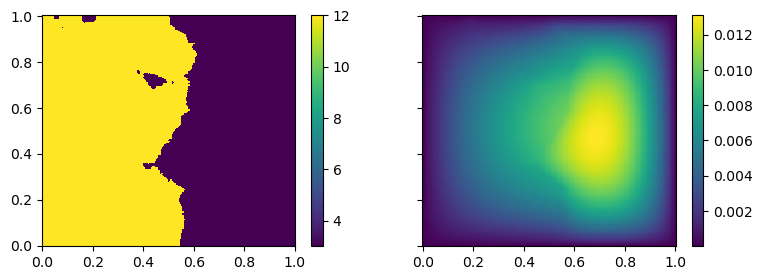

In [ ]:
Np = 211
ind = 0
fig, axs = plt.subplots(1, 2, figsize=(9,3), sharex=True, sharey=True)
for i in range(2):
    pcm = axs[i].pcolormesh(nodes[ind,:,0].reshape((Np,Np)), nodes[ind,:,1].reshape((Np,Np)), features[ind,:,i].reshape((Np,Np)))
    fig.colorbar(pcm, ax=axs[i])

In [ ]:
n_test = 3
gradient = compute_gradient(features[0:n_test,...].permute(0,2,1), directed_edges[0:n_test,...], edge_gradient_weights[0:n_test,...])

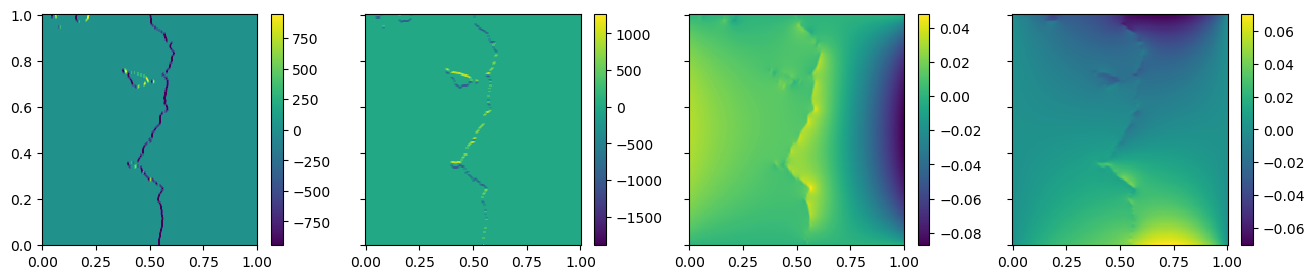

In [ ]:
Np = 211
ind = 0
fig, axs = plt.subplots(1, 4, figsize=(16,3), sharex=True, sharey=True)
for i in range(4):
    pcm = axs[i].pcolormesh(nodes[ind,:,0].reshape((Np,Np)), nodes[ind,:,1].reshape((Np,Np)), gradient[ind,i,:].reshape((Np,Np)))
    fig.colorbar(pcm, ax=axs[i])


#### Example3: Airfoil Problem

In [ ]:
data = np.load("../data/airfoil/pcno_quad_data.npz")
nnodes, node_mask, nodes, node_weights, features, directed_edges, edge_gradient_weights = data["nnodes"], data["node_mask"], data["nodes"], data["node_weights"], data["features"], data["directed_edges"], data["edge_gradient_weights"]

###################################
# prepare data
###################################

print("Casting to tensor")
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges.astype(np.int64))
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))

Casting to tensor


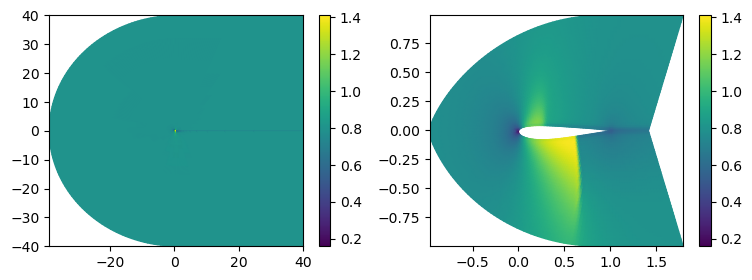

In [ ]:
Npx, Npy = 221, 51
ind = 4
fig, axs = plt.subplots(1, 2, figsize=(9,3), sharex=False, sharey=False)
pcm = axs[0].pcolormesh(nodes[ind,:,0].reshape((Npx, Npy)), nodes[ind,:,1].reshape((Npx, Npy)), features[ind,:,0].reshape((Npx, Npy)), shading="gouraud")
fig.colorbar(pcm, ax=axs[0])


cny, cnx = 40, 30 # how many layer to compute 
pcm = axs[1].pcolormesh(nodes[ind,:,0].reshape((Npx, Npy))[cnx:-cnx, 0:cny], nodes[ind,:,1].reshape((Npx, Npy))[cnx:-cnx, 0:cny], features[ind,:,0].reshape((Npx, Npy))[cnx:-cnx, 0:cny], shading="gouraud")
fig.colorbar(pcm, ax=axs[1])

In [ ]:
n_test = 5
gradient = compute_gradient(features[0:n_test,...].permute(0,2,1), directed_edges[0:n_test,...], edge_gradient_weights[0:n_test,...])

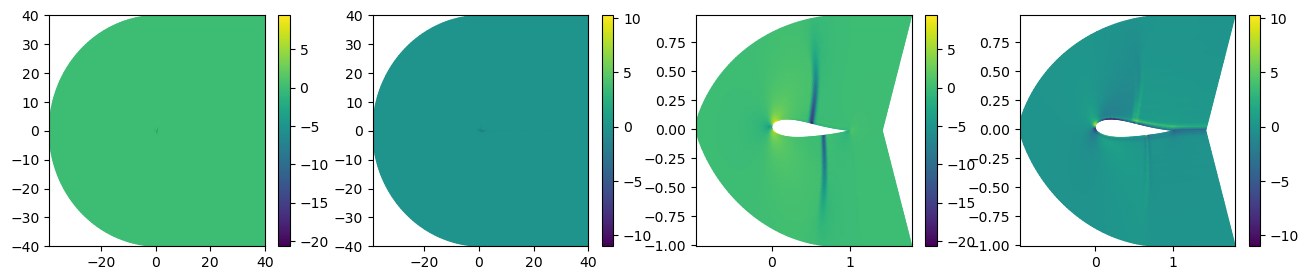

In [ ]:
Npx, Npy = 221, 51
Np = 211
ind = 0

fig, axs = plt.subplots(1, 4, figsize=(16,3), sharex=False, sharey=False)
for i in range(2):
    pcm = axs[i].pcolormesh(nodes[ind,:,0].reshape((Npx, Npy)), nodes[ind,:,1].reshape((Npx, Npy)), gradient[ind,i,:].reshape((Npx, Npy)), shading="gouraud")
    fig.colorbar(pcm, ax=axs[i])

cny, cnx = 40, 30 # how many layer to compute 
for i in range(2):
    pcm = axs[i+2].pcolormesh(nodes[ind,:,0].reshape((Npx, Npy))[cnx:-cnx, 0:cny], nodes[ind,:,1].reshape((Npx, Npy))[cnx:-cnx, 0:cny], gradient[ind,i,:].reshape((Npx, Npy))[cnx:-cnx, 0:cny], shading="gouraud")
    fig.colorbar(pcm, ax=axs[i+2])

#### Example4: ShapeNet Car

In [ ]:
data = np.load("../data/car_shapenet/pcno_triangle_data.npz")
nnodes, node_mask, nodes, node_weights, features, directed_edges, edge_gradient_weights = data["nnodes"], data["node_mask"], data["nodes"], data["node_weights"], data["features"], data["directed_edges"], data["edge_gradient_weights"]

###################################
# prepare data
###################################

print("Casting to tensor")
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges.astype(np.int64))
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))
print(features.shape)

Casting to tensor
torch.Size([3, 3586, 4])


Text(0.5, 0.92, 'Pressure')

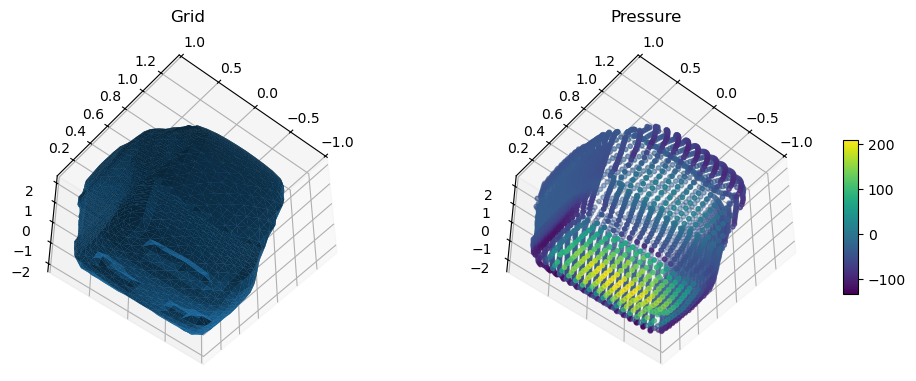

In [ ]:
ind = 0
elems = np.load("../data/car_shapenet/elems_%05d"%(ind)+".npy")[:,1:]

fig, ax = plt.subplots(1, 2,figsize=(12,4), subplot_kw={'projection': '3d'})
surf1 = ax[0].plot_trisurf(
    nodes[ind, :, 0], nodes[ind, :, 1], nodes[ind, :, 2], triangles=elems
)
surf2 = ax[1].scatter(nodes[ind,:, 0], nodes[ind,:, 1], nodes[ind,:, 2], c=features[ind, :,0], s=10)
fig.colorbar(surf2, ax=ax[1], shrink=0.5, aspect=10, pad=0.1)
ax[0].view_init(elev=-50, azim=50)
ax[1].view_init(elev=-50, azim=50) 
ax[0].set_title("Grid", pad=30)
ax[1].set_title("Pressure", pad=30)

We first examine the gradient of the X-coordinates $\nabla X(x,y,z)$

Text(0.5, 0.92, '$\\partial X /\\partial y$')

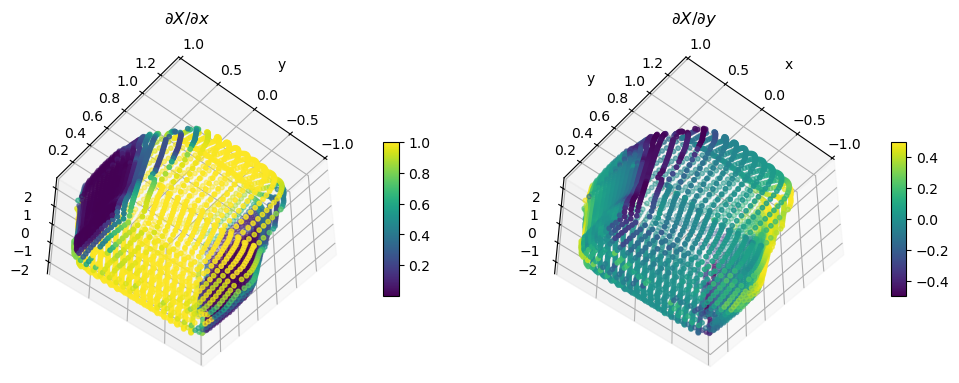

In [ ]:
n_test = 3
gradient = compute_gradient(nodes[0:n_test,:,:].permute(0,2,1), directed_edges[0:n_test,...], edge_gradient_weights[0:n_test,...])

ind = 0
fig, ax = plt.subplots(1, 2,figsize=(12,4), subplot_kw={'projection': '3d'})


surf1 = ax[0].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=gradient[ind, 0, :nnodes[ind]], s=10)
fig.colorbar(surf1 , ax=ax[0], shrink=0.5, aspect=10, pad=0.1)
ax[0].view_init(elev=-50, azim=50)
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].set_title(r'$\partial X /\partial x$', pad=30)

surf2 = ax[1].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=gradient[ind, 1, :nnodes[ind]], s=10)
fig.colorbar(surf2 , ax=ax[1], shrink=0.5, aspect=10, pad=0.1)
ax[1].view_init(elev=-50, azim=50)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title(r'$\partial X /\partial y$', pad=30)

and then visualize the gradient of the pressure $\nabla p(x, y, z)$

Text(0.5, 0.92, '$\\partial p /\\partial y$')

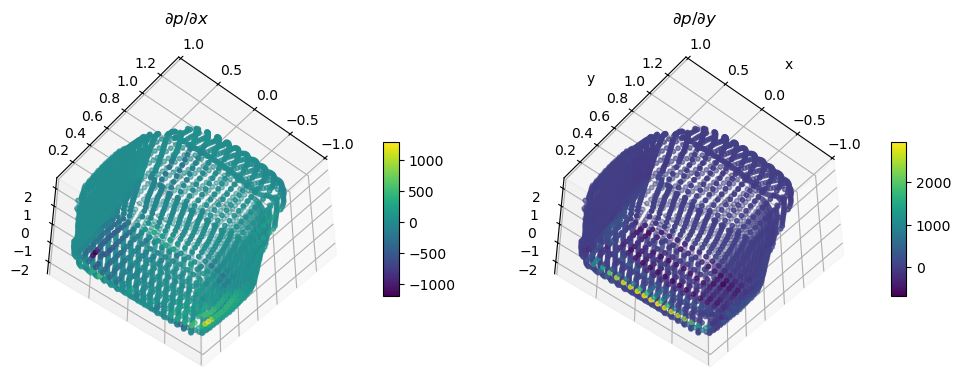

In [ ]:
n_test = 3
gradient = compute_gradient(features[0:n_test,:,[0]].permute(0,2,1), directed_edges[0:n_test,...], edge_gradient_weights[0:n_test,...])

ind = 0
fig, ax = plt.subplots(1, 2,figsize=(12,4), subplot_kw={'projection': '3d'})


surf1 = ax[0].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=gradient[ind, 0, :nnodes[ind]], s=10)
fig.colorbar(surf1 , ax=ax[0], shrink=0.5, aspect=10, pad=0.1)
ax[0].view_init(elev=-50, azim=50)
ax[0].set_title(r'$\partial p /\partial x$', pad=30)

surf2 = ax[1].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=gradient[ind, 1, :nnodes[ind]], s=10)
fig.colorbar(surf2 , ax=ax[1], shrink=0.5, aspect=10, pad=0.1)
ax[1].view_init(elev=-50, azim=50)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title(r'$\partial p /\partial y$', pad=30)

#### Example5: Ahmed-Body

In [ ]:
data = np.load("../data/ahmed_body/ahmed_bodypcno_triangle_data.npz")
nnodes, node_mask, nodes, node_weights, features, directed_edges, edge_gradient_weights = data["nnodes"], data["node_mask"], data["nodes"], data["node_weights"], data["features"], data["directed_edges"], data["edge_gradient_weights"]

###################################
# prepare data
###################################

print("Casting to tensor")
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges.astype(np.int64))
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))

Casting to tensor


Text(0.5, 0.92, 'Pressure')

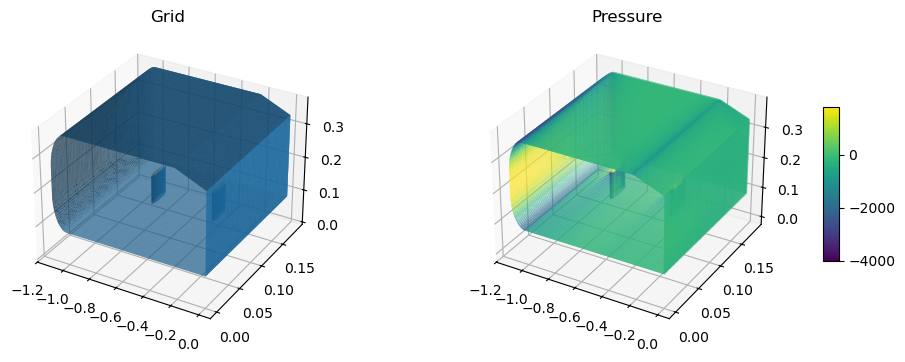

In [ ]:
ind = 1
elems = np.load("../data/ahmed_body/elems_%05d"%(ind)+".npy")[:,1:]

fig, ax = plt.subplots(1, 2,figsize=(12,4), subplot_kw={'projection': '3d'})
surf1 = ax[0].plot_trisurf(
    nodes[ind, :, 0], nodes[ind, :, 1], nodes[ind, :, 2], triangles=elems
)
surf2 = ax[1].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=features[ind, :nnodes[ind], 0], s=0.1)
fig.colorbar(surf2, ax=ax[1], shrink=0.5, aspect=10, pad=0.1)
ax[0].set_title("Grid")
ax[1].set_title("Pressure")

Text(0.5, 0.98, '$\\partial p /\\partial z$')

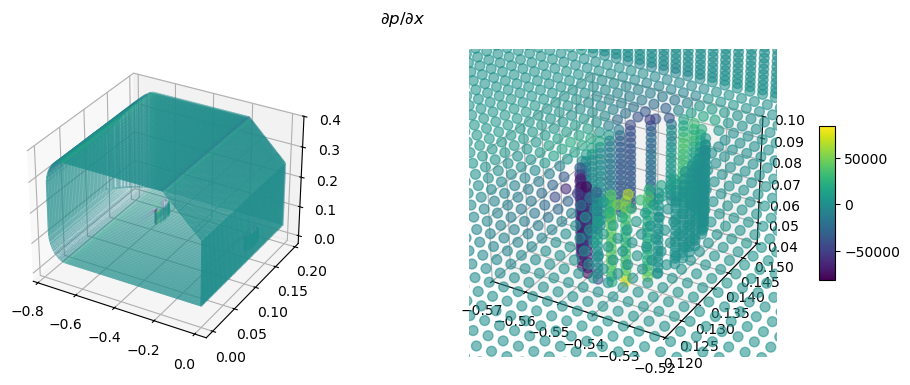

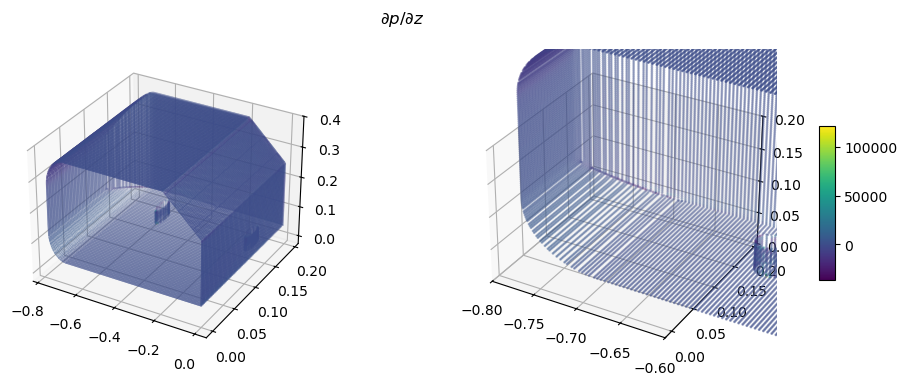

In [ ]:
n_test = 3
gradient = compute_gradient(features[0:n_test,:,[0]].permute(0,2,1), directed_edges[0:n_test,...], edge_gradient_weights[0:n_test,...])

ind = 0

fig, ax = plt.subplots(1, 2,figsize=(12,4), subplot_kw={'projection': '3d'})
surf1= ax[0].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=gradient[ind, 0, :nnodes[ind]], s=0.1)
surf2= ax[1].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=gradient[ind, 0, :nnodes[ind]], s=50)
fig.colorbar(surf2 , ax=ax[1], shrink=0.5, aspect=10, pad=0.1)
ax[1].set_xlim(-0.57,-0.52)
ax[1].set_ylim(0.12,0.15)
ax[1].set_zlim(0.04,0.1)
fig.suptitle(r'$\partial p /\partial x$')

fig, ax = plt.subplots(1, 2,figsize=(12,4), subplot_kw={'projection': '3d'})
surf1= ax[0].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=gradient[ind, 2, :nnodes[ind]], s=0.1)
surf2= ax[1].scatter(nodes[ind,:nnodes[ind], 0], nodes[ind,:nnodes[ind], 1], nodes[ind,:nnodes[ind], 2], c=gradient[ind, 2, :nnodes[ind]], s=1)
fig.colorbar(surf2 , ax=ax[1], shrink=0.5, aspect=10, pad=0.1)
ax[1].set_xlim(-0.8,-0.6)
# ax[1].set_ylim(0.12,0.15)
ax[1].set_zlim(0,0.2)
fig.suptitle(r'$\partial p /\partial z$')